# Vari metodi di classificazione

Accuracy: 0.78
Precision: 0.84
Recall: 0.78
F1-Score: 0.78
              precision    recall  f1-score   support

      attack       0.97      0.63      0.77     12833
      normal       0.67      0.97      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.82      0.80      0.78     22544
weighted avg       0.84      0.78      0.78     22544



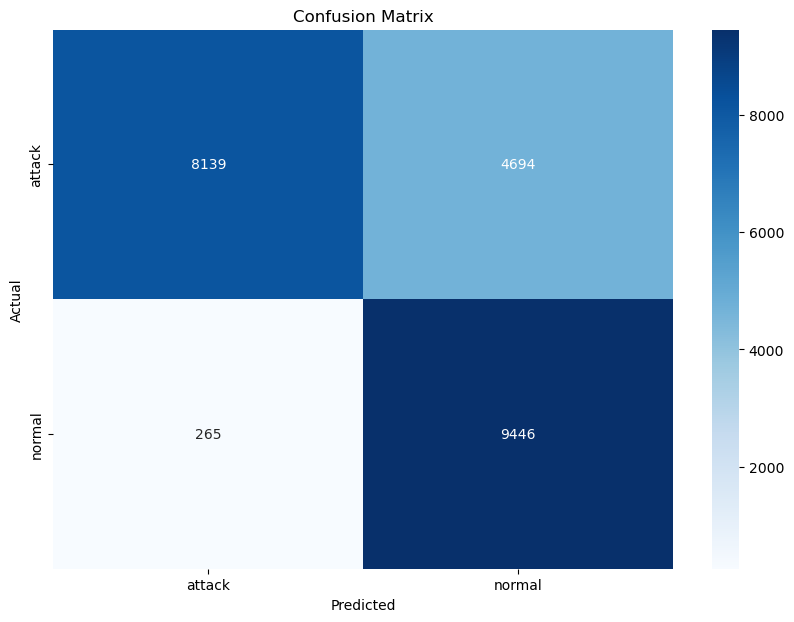

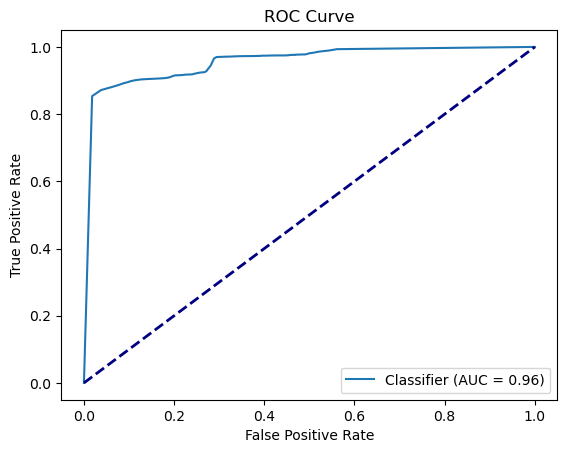

In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from utility import Dataset, oh_encoder, t_encoder

train_df = pd.read_csv(f'KDDTrain+.txt', header=None)
test_df = pd.read_csv(f'KDDTest+.txt', header=None)

train_df = Dataset(train_df).get_label2()
test_df = Dataset(test_df).get_label2()

train_df, test_df = t_encoder(train_df, test_df, ['service', ])
train_df, test_df = oh_encoder(train_df, test_df, ['protocol_type', 'flag'])


# dividi train set e test set in X e y
X_train = train_df.drop(['label', 'score'], axis=1)
y_train = train_df['label']
X_test = test_df.drop(['label', 'score'], axis=1)
y_test = test_df['label']

# random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# valuta il modello
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # 'weighted' gestisce classi sbilanciate
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

print(classification_report(y_test, y_pred, target_names=rf.classes_))

cm = confusion_matrix(y_test, y_pred)

# Visualizzazione con una heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['attack', 'normal'], yticklabels=['attack', 'normal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calcolare le curve ROC
y_score = rf.predict_proba(X_test)
RocCurveDisplay.from_predictions(y_test, y_score[:, 1], pos_label='normal')
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
# # Plot della curva ROC
# plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])